# Kaggle Playground Competition Season 5 - Episode 7: Predicting Introverts from Extroverts

In this notebook, we will be working through July 2025's Kaggle Playground competition intending to **predict introverts from extroverts**. My specific intention with my participation is **learning and keeping my existing skills sharp**! I definitely don't expect to win, but that would be a nice bonus. 😁

Note: I did all my work in this Jupyter notebook on my local Mac mini but have made it compatible for uploading / using directly on Kaggle.

## Notebook Setup
Let's set ourselves up for success by doing all the necessary "administrative overhead" for our work!

In [1]:
# Importing the necessary Python libraries
import os
import json
import warnings
from collections import Counter

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import optuna
import umap
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

/Users/dkhundley/Documents/Repositories/kaggle-playground-competitions/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Suppressing warnings
warnings.filterwarnings("ignore")

In [3]:
# Loading the raw data from the respective test and train files provided by Kaggle
df_train_raw = pl.read_csv('data/raw/train.csv')
df_test_raw = pl.read_csv('data/raw/test.csv')

In [4]:
# Setting custom toggles for when to run certain parts of code
RUN_CLUSTERING_VISUALIZATIONS = False
RUN_OPTUNA_HYPERPARAMETER_TUNING = False
TEST_CANDIDATE_MODELS = False

## Exploratory Data Analysis
In this section, we'll begin to explore the data in its raw form to determine what sort of feature engineering will need to be formally completed, which we'll address in the next section. In order to do an effective EDA, we may need to engineer some of this data in a way that makes sense, but this shouldn't be mistaken for feature engineering. (Although some of this EDA engineering may translate over to feature engineering.)

### Meta Analysis
Let's get a general gist of the data we're working with, including assessing nulls. Before we jump into the code itself, let's outline what each of the provided features refer to across this dataset.

- `id`: Unique identifier for the row
- `Time_spent_Alone`: Number of hours spent alone daily (range: 0-11)
- `Stage_fear`: Presence of stage fright (Yes / No)
- `Social_event_attendance`: Frequency of going to social events (range: 0-10)
- `Going_outside`: Frequency of going outside (range: 0-7)
- `Drained_after_socializing`: Feeling drained after socializing (Yes / No)
- `Friends_circle_size`: Number of close friends (range: 0-15)
- `Post_frequency`: Social media post frequency (range: 0-10)
- `Personality`: Target variable ("Extrovert" / "Introvert")

In [5]:
# Randomly sampling 10 records from df_train_raw
df_train_raw.sample(n = 10)

id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
i64,f64,str,f64,f64,str,f64,f64,str
475,0.0,"""No""",4.0,7.0,"""No""",9.0,5.0,"""Extrovert"""
13995,2.0,null,5.0,4.0,"""No""",13.0,7.0,"""Extrovert"""
8895,3.0,"""No""",8.0,3.0,"""No""",13.0,5.0,"""Extrovert"""
16995,7.0,null,2.0,0.0,"""Yes""",5.0,1.0,"""Introvert"""
3083,1.0,"""No""",7.0,null,"""No""",15.0,7.0,"""Extrovert"""
12939,0.0,"""No""",9.0,null,"""No""",9.0,5.0,"""Extrovert"""
630,2.0,null,8.0,6.0,"""No""",12.0,7.0,"""Extrovert"""
14418,3.0,"""No""",6.0,6.0,"""No""",6.0,6.0,"""Extrovert"""
13863,0.0,"""No""",5.0,7.0,"""No""",13.0,4.0,"""Extrovert"""


In [6]:
# Viewing the general statistics of the training data
df_train_raw.describe()

statistic,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
str,f64,f64,str,f64,f64,str,f64,f64,str
"""count""",18524.0,17334.0,"""16631""",17344.0,17058.0,"""17375""",17470.0,17260.0,"""18524"""
"""null_count""",0.0,1190.0,"""1893""",1180.0,1466.0,"""1149""",1054.0,1264.0,"""0"""
"""mean""",9261.5,3.137764,null,5.265106,4.044319,null,7.996737,4.982097,null
"""std""",5347.562529,3.003786,null,2.753359,2.06258,null,4.223484,2.879139,null
"""min""",0.0,0.0,"""No""",0.0,0.0,"""No""",0.0,0.0,"""Extrovert"""
"""25%""",4631.0,1.0,null,3.0,3.0,null,5.0,3.0,null
"""50%""",9262.0,2.0,null,5.0,4.0,null,8.0,5.0,null
"""75%""",13892.0,4.0,null,8.0,6.0,null,12.0,7.0,null
"""max""",18523.0,11.0,"""Yes""",10.0,7.0,"""Yes""",15.0,10.0,"""Introvert"""


In [7]:
# Counting the number of null values in each column of df_train_raw
null_counts = df_train_raw.null_count()

# Displaying null counts as a table with feature names and number of nulls
pl.DataFrame({
    "feature": null_counts.columns,
    "num_nulls": null_counts.row(0)
})

feature,num_nulls
str,i64
"""id""",0
"""Time_spent_Alone""",1190
"""Stage_fear""",1893
"""Social_event_attendance""",1180
"""Going_outside""",1466
"""Drained_after_socializing""",1149
"""Friends_circle_size""",1054
"""Post_frequency""",1264
"""Personality""",0


### Univariate Analysis
Now that we've glanced at the data at a high level, let's take a more focused approach by performing a univariate analysis on all the provided features. As part of this univariate analysis, we will also compare the individual feature to the target variable. Technically speaking, I recognize that comparing a single feature to the target variable is a bivariate analysis, but I still want to loop it in this subsection as I intend to explore a multivariate analysis in the next subsection.

Let's jump into our analysis of each respective feature. Note: Because `id` simply represents a unique identifier for the row, we won't be doing any sort of analysis there since this feature will definitely not play a hand in later model training and inference.

#### Target variable: `Personality`
Given that our intention is to also compare each of the supporting features to the target variable in this section, I thought it would be good to first look at the target variable `Personality` in and of itself.

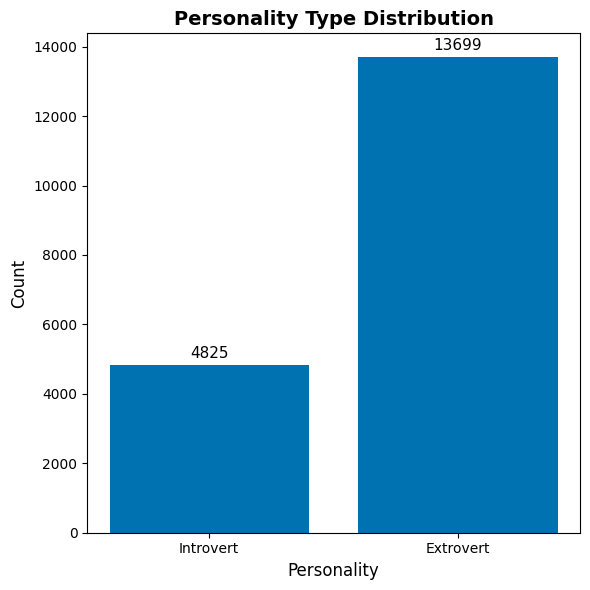

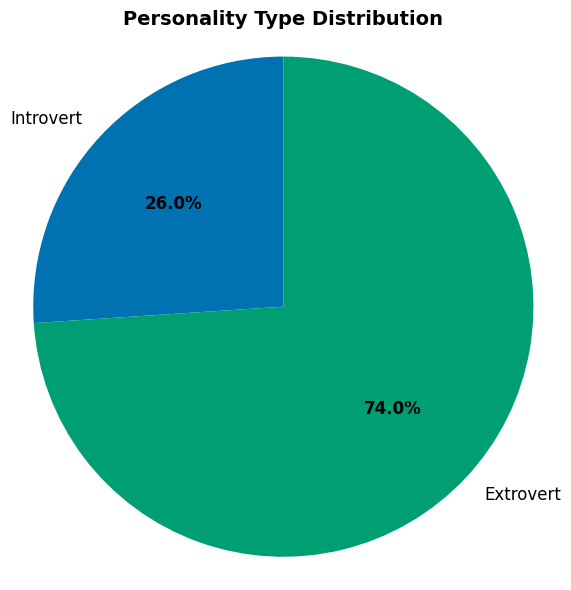

In [8]:
# Counting occurrences of each Personality type using polars
personality_counts = (
	df_train_raw
		.group_by("Personality")
		.len()
		.rename({"len": "count"})
		.select(["Personality", "count"])
		.to_pandas()
)

# Setting a consistent style for plots
plt.style.use("seaborn-v0_8-colorblind")

# Plotting the distribution of Personality types using a bar chart
fig, ax = plt.subplots(figsize = (6, 6))
bars = ax.bar(
	personality_counts["Personality"],
	personality_counts["count"]
)
ax.set_xlabel("Personality", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Personality Type Distribution", fontsize = 14, weight = "bold")
ax.bar_label(bars, padding = 3, fontsize = 11)
plt.tight_layout()
plt.show()

# Plotting the distribution as a pie chart
fig, ax = plt.subplots(figsize = (6, 6))
wedges, texts, autotexts = ax.pie(
	personality_counts["count"],
	labels=personality_counts["Personality"],
	autopct='%1.1f%%',
	startangle=90,
	textprops={'fontsize': 12}
)
ax.set_title("Personality Type Distribution", fontsize = 14, weight = "bold")
plt.setp(autotexts, weight="bold")
ax.axis('equal')
plt.tight_layout()
plt.show()

#### Feature 1: `Time_spent_Alone`

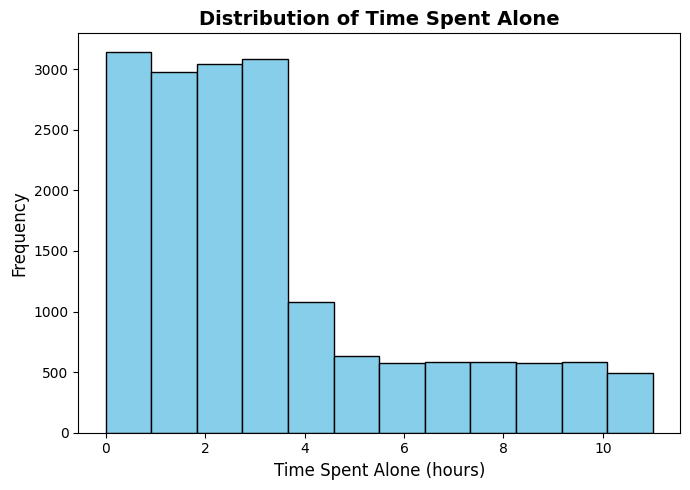

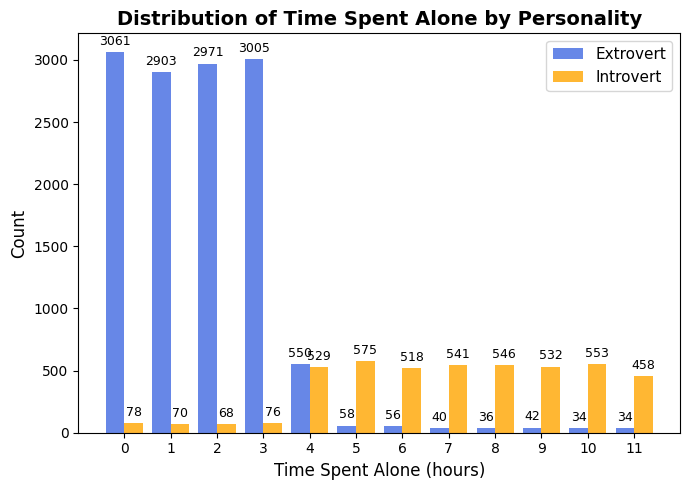

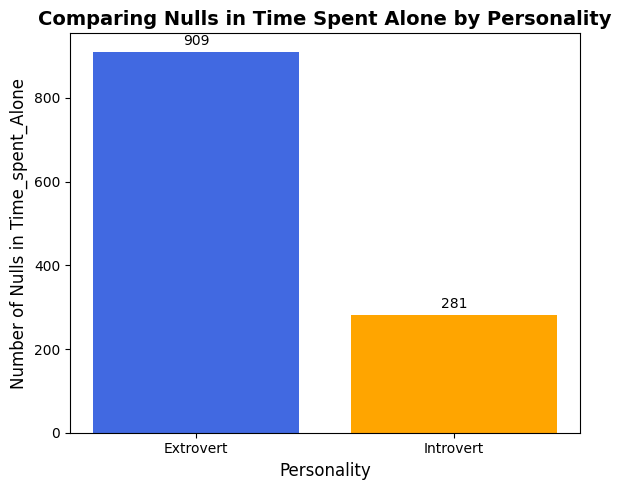

In [9]:
## VISUALIZATION 1: DISTRIBUTION OF TIME SPENT ALONE
## -------------------------------------------------------------------------------------
# Dropping null values from Time_spent_Alone and converting to numpy array for plotting
time_spent_alone = (
    df_train_raw
        .select("Time_spent_Alone")
        .drop_nulls()
        .to_numpy()
        .flatten()
)

# Plotting the histogram of Time_spent_Alone while ignoring nulls
fig, ax = plt.subplots(figsize = (7, 5))
ax.hist(time_spent_alone, bins = 12, color = "skyblue", edgecolor = "black")
ax.set_xlabel("Time Spent Alone (hours)", fontsize = 12)
ax.set_ylabel("Frequency", fontsize = 12)
ax.set_title("Distribution of Time Spent Alone", fontsize = 14, weight = "bold")
plt.tight_layout()
plt.show()



## VISUALIZATION 2: DISTRIBUTION OF TIME SPENT ALONE BY PERSONALITY
## -------------------------------------------------------------------------------------
# Creating separate arrays for Time_spent_Alone by Personality
time_spent_alone_extrovert = (
    df_train_raw
        .filter(pl.col("Personality") == "Extrovert")
        .select("Time_spent_Alone")
        .drop_nulls()
        .to_numpy()
        .flatten()
)
time_spent_alone_introvert = (
    df_train_raw
        .filter(pl.col("Personality") == "Introvert")
        .select("Time_spent_Alone")
        .drop_nulls()
        .to_numpy()
        .flatten()
)

# Calculating the value counts for each integer value of Time_spent_Alone by Personality
extrovert_counts = np.bincount(time_spent_alone_extrovert.astype(int), minlength = 12)
introvert_counts = np.bincount(time_spent_alone_introvert.astype(int), minlength = 12)
x = np.arange(12)

# Creating a grouped bar plot to compare distributions
fig, ax = plt.subplots(figsize = (7, 5))
width = 0.4

# Plotting Extrovert bars
bars_extrovert = ax.bar(x - width / 2, extrovert_counts, width = width, label = "Extrovert", color = "royalblue", alpha = 0.8)

# Plotting Introvert bars
bars_introvert = ax.bar(x + width / 2, introvert_counts, width = width, label = "Introvert", color = "orange", alpha = 0.8)

# Adding count labels on each bar
for bar in bars_extrovert:
    height = bar.get_height()
    if height > 0:
        ax.annotate(f"{int(height)}",
                    xy = (bar.get_x() + bar.get_width() / 2, height),
                    xytext = (0, 3),
                    textcoords = "offset points",
                    ha = "center", va = "bottom", fontsize = 9)

for bar in bars_introvert:
    height = bar.get_height()
    if height > 0:
        ax.annotate(f"{int(height)}",
                    xy = (bar.get_x() + bar.get_width() / 2, height),
                    xytext = (0, 3),
                    textcoords = "offset points",
                    ha = "center", va = "bottom", fontsize = 9)

# Adding labels and title
ax.set_xlabel("Time Spent Alone (hours)", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Distribution of Time Spent Alone by Personality", fontsize = 14, weight = "bold")
ax.set_xticks(x)
ax.legend(fontsize = 11)
plt.tight_layout()
plt.show()



## VISUALIZATION 3: COMPARING NULLS IN TIME SPENT ALONE BY PERSONALITY
## -------------------------------------------------------------------------------------
# Calculating the number of nulls in Time_spent_Alone for each Personality
nulls_by_personality = (
    df_train_raw
        .select(["Personality", "Time_spent_Alone"])
        .with_columns(
            pl.col("Time_spent_Alone").is_null().alias("is_null")
        )
        .group_by("Personality")
        .agg(
            pl.col("is_null").sum().alias("num_nulls"),
            pl.len().alias("total")
        )
        .with_columns(
            (pl.col("num_nulls") / pl.col("total") * 100).alias("percent_nulls")
        )
        .to_pandas()
)

# Plotting the null counts as a bar chart
fig, ax = plt.subplots(figsize = (6, 5))
bars = ax.bar(
    nulls_by_personality["Personality"],
    nulls_by_personality["num_nulls"],
    color = ["royalblue", "orange"]
)

# Adding count labels on each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{int(height)}",
        xy = (bar.get_x() + bar.get_width() / 2, height),
        xytext = (0, 3),
        textcoords = "offset points",
        ha = "center", va = "bottom", fontsize = 10
    )

# Adding labels and title
ax.set_xlabel("Personality", fontsize = 12)
ax.set_ylabel("Number of Nulls in Time_spent_Alone", fontsize = 12)
ax.set_title("Comparing Nulls in Time Spent Alone by Personality", fontsize = 14, weight = "bold")
plt.tight_layout()
plt.show()

#### Feature 2: `Stage_fear`

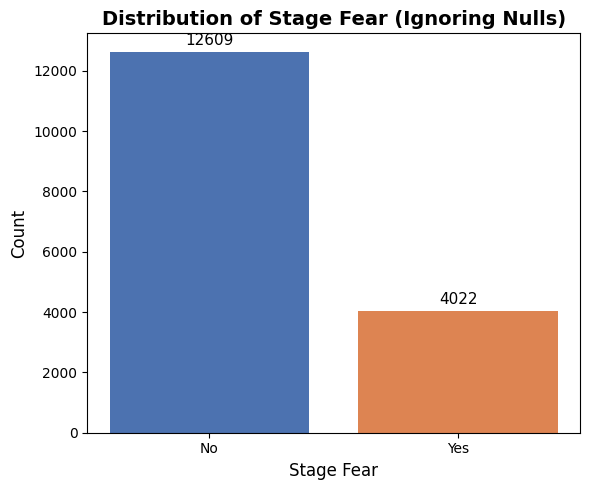

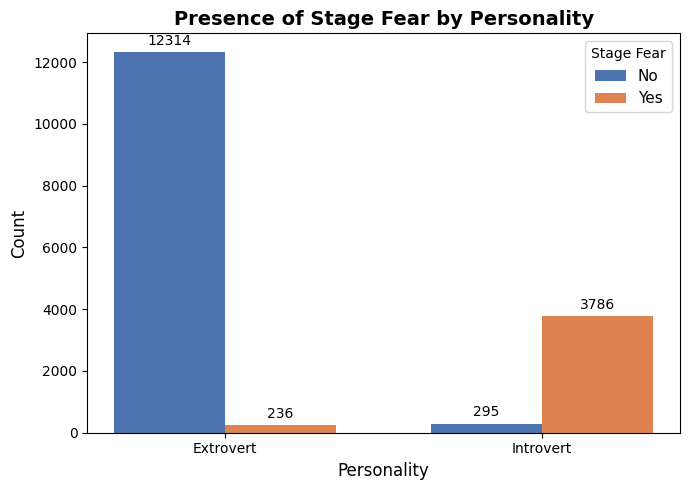

In [10]:
## VISUALIZATION 1: DISTRIBUTION OF STAGE FEAR
## -------------------------------------------------------------------------------------
# Filtering out nulls from Stage_fear and counting occurrences of "Yes" and "No"
stage_fear_counts = (
    df_train_raw
        .filter(pl.col("Stage_fear").is_not_null())
        .group_by("Stage_fear")
        .len()
        .rename({"len": "count"})
        .sort("Stage_fear")
        .to_pandas()
)

# Plotting the distribution of Stage_fear values as a bar chart with different colors
fig, ax = plt.subplots(figsize = (6, 5))
bar_colors = ["#4C72B0", "#DD8452"]  # Assigning different colors for "No" and "Yes"
bars = ax.bar(
    stage_fear_counts["Stage_fear"],
    stage_fear_counts["count"],
    color = bar_colors
)
ax.set_xlabel("Stage Fear", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Distribution of Stage Fear (Ignoring Nulls)", fontsize = 14, weight = "bold")
ax.bar_label(bars, padding = 3, fontsize = 11)
plt.tight_layout()
plt.show()



## VISUALIZATION 2: PRESENCE OF STAGE FEAR BY PERSONALITY
## -------------------------------------------------------------------------------------
# Counting occurrences of Stage_fear ("Yes"/"No") for each Personality
stage_fear_by_personality = (
    df_train_raw
        .filter(pl.col("Stage_fear").is_not_null())
        .group_by(["Personality", "Stage_fear"])
        .len()
        .rename({"len": "count"})
        .sort(["Personality", "Stage_fear"])
        .to_pandas()
)

# Pivoting the table for grouped bar plot
pivot = stage_fear_by_personality.pivot(index = "Personality", columns = "Stage_fear", values = "count").fillna(0)

# Plotting grouped bar chart
fig, ax = plt.subplots(figsize = (7, 5))
bar_width = 0.35
x = np.arange(len(pivot.index))

bars_no = ax.bar(x - bar_width / 2, pivot["No"], width = bar_width, label = "No", color = bar_colors[0])
bars_yes = ax.bar(x + bar_width / 2, pivot["Yes"], width = bar_width, label = "Yes", color = bar_colors[1])

# Adding count labels on each bar
for bars in [bars_no, bars_yes]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f"{int(height)}",
                        xy = (bar.get_x() + bar.get_width() / 2, height),
                        xytext = (0, 3),
                        textcoords = "offset points",
                        ha = "center", va = "bottom", fontsize = 10)

# Adding labels and title
ax.set_xlabel("Personality", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Presence of Stage Fear by Personality", fontsize = 14, weight = "bold")
ax.set_xticks(x)
ax.set_xticklabels(pivot.index)
ax.legend(title = "Stage Fear", fontsize = 11)
plt.tight_layout()
plt.show()

#### Feature 3: `Social_event_attendance`

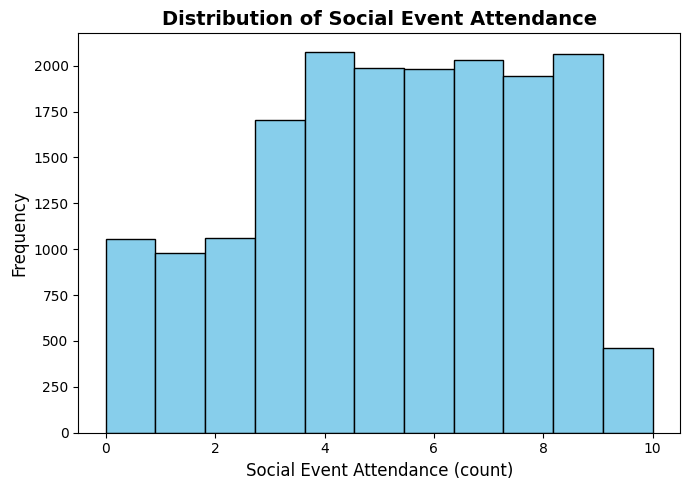

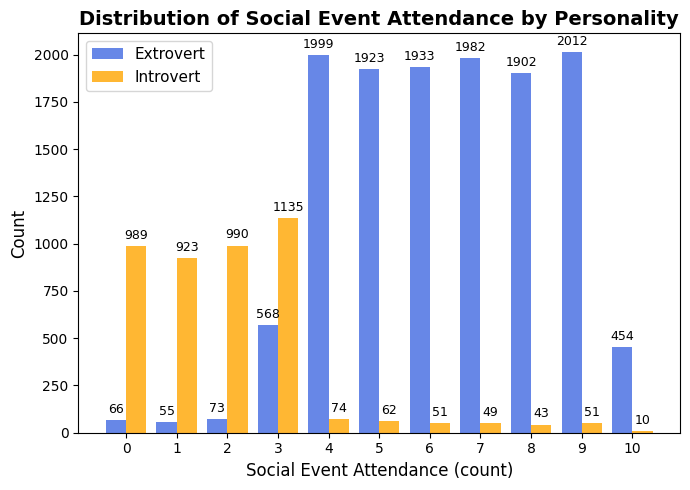

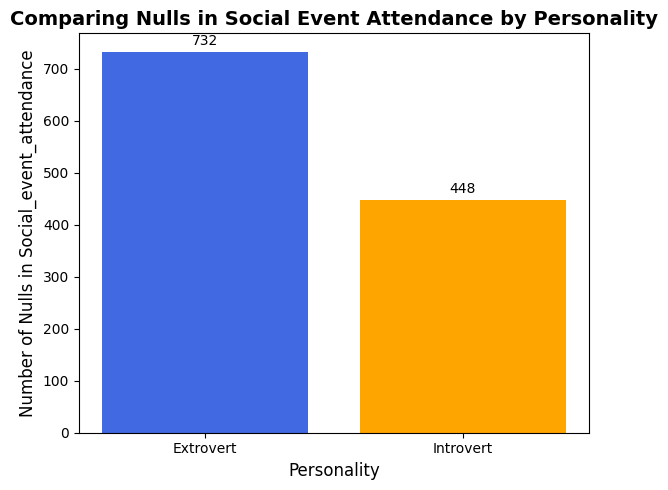

In [11]:
## VISUALIZATION 1: DISTRIBUTION OF SOCIAL EVENT ATTENDANCE
## -------------------------------------------------------------------------------------
# Dropping null values from Social_event_attendance and converting to numpy array for plotting
social_event_attendance = (
    df_train_raw
        .select("Social_event_attendance")
        .drop_nulls()
        .to_numpy()
        .flatten()
)

# Plotting the histogram of Social_event_attendance while ignoring nulls
fig, ax = plt.subplots(figsize = (7, 5))
ax.hist(social_event_attendance, bins = 11, color = "skyblue", edgecolor = "black")
ax.set_xlabel("Social Event Attendance (count)", fontsize = 12)
ax.set_ylabel("Frequency", fontsize = 12)
ax.set_title("Distribution of Social Event Attendance", fontsize = 14, weight = "bold")
plt.tight_layout()
plt.show()



## VISUALIZATION 2: DISTRIBUTION OF SOCIAL EVENT ATTENDANCE BY PERSONALITY
## -------------------------------------------------------------------------------------
# Creating separate arrays for Social_event_attendance by Personality
social_event_attendance_extrovert = (
    df_train_raw
        .filter(pl.col("Personality") == "Extrovert")
        .select("Social_event_attendance")
        .drop_nulls()
        .to_numpy()
        .flatten()
)
social_event_attendance_introvert = (
    df_train_raw
        .filter(pl.col("Personality") == "Introvert")
        .select("Social_event_attendance")
        .drop_nulls()
        .to_numpy()
        .flatten()
)

# Calculating the value counts for each integer value of Social_event_attendance by Personality
extrovert_counts = np.bincount(social_event_attendance_extrovert.astype(int), minlength = 11)
introvert_counts = np.bincount(social_event_attendance_introvert.astype(int), minlength = 11)
x = np.arange(11)

# Creating a grouped bar plot to compare distributions
fig, ax = plt.subplots(figsize = (7, 5))
width = 0.4

# Plotting Extrovert bars
bars_extrovert = ax.bar(x - width / 2, extrovert_counts, width = width, label = "Extrovert", color = "royalblue", alpha = 0.8)

# Plotting Introvert bars
bars_introvert = ax.bar(x + width / 2, introvert_counts, width = width, label = "Introvert", color = "orange", alpha = 0.8)

# Adding count labels on each bar
for bar in bars_extrovert:
    height = bar.get_height()
    if height > 0:
        ax.annotate(f"{int(height)}",
                    xy = (bar.get_x() + bar.get_width() / 2, height),
                    xytext = (0, 3),
                    textcoords = "offset points",
                    ha = "center", va = "bottom", fontsize = 9)

for bar in bars_introvert:
    height = bar.get_height()
    if height > 0:
        ax.annotate(f"{int(height)}",
                    xy = (bar.get_x() + bar.get_width() / 2, height),
                    xytext = (0, 3),
                    textcoords = "offset points",
                    ha = "center", va = "bottom", fontsize = 9)

# Adding labels and title
ax.set_xlabel("Social Event Attendance (count)", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Distribution of Social Event Attendance by Personality", fontsize = 14, weight = "bold")
ax.set_xticks(x)
ax.legend(fontsize = 11)
plt.tight_layout()
plt.show()



## VISUALIZATION 3: COMPARING NULLS IN SOCIAL EVENT ATTENDANCE BY PERSONALITY
## -------------------------------------------------------------------------------------
# Calculating the number of nulls in Social_event_attendance for each Personality
nulls_by_personality = (
    df_train_raw
        .select(["Personality", "Social_event_attendance"])
        .with_columns(
            pl.col("Social_event_attendance").is_null().alias("is_null")
        )
        .group_by("Personality")
        .agg(
            pl.col("is_null").sum().alias("num_nulls"),
            pl.len().alias("total")
        )
        .with_columns(
            (pl.col("num_nulls") / pl.col("total") * 100).alias("percent_nulls")
        )
        .to_pandas()
)

# Plotting the null counts as a bar chart
fig, ax = plt.subplots(figsize = (6, 5))
bars = ax.bar(
    nulls_by_personality["Personality"],
    nulls_by_personality["num_nulls"],
    color = ["royalblue", "orange"]
)

# Adding count labels on each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{int(height)}",
        xy = (bar.get_x() + bar.get_width() / 2, height),
        xytext = (0, 3),
        textcoords = "offset points",
        ha = "center", va = "bottom", fontsize = 10
    )

# Adding labels and title
ax.set_xlabel("Personality", fontsize = 12)
ax.set_ylabel("Number of Nulls in Social_event_attendance", fontsize = 12)
ax.set_title("Comparing Nulls in Social Event Attendance by Personality", fontsize = 14, weight = "bold")
plt.tight_layout()
plt.show()

#### Feature 4: `Going_outside`

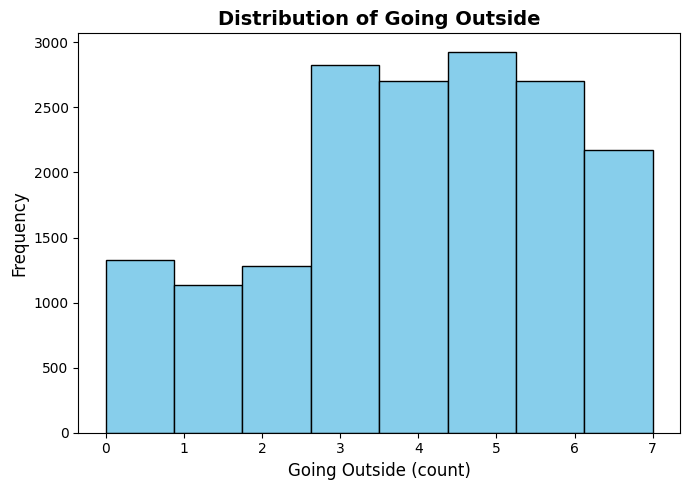

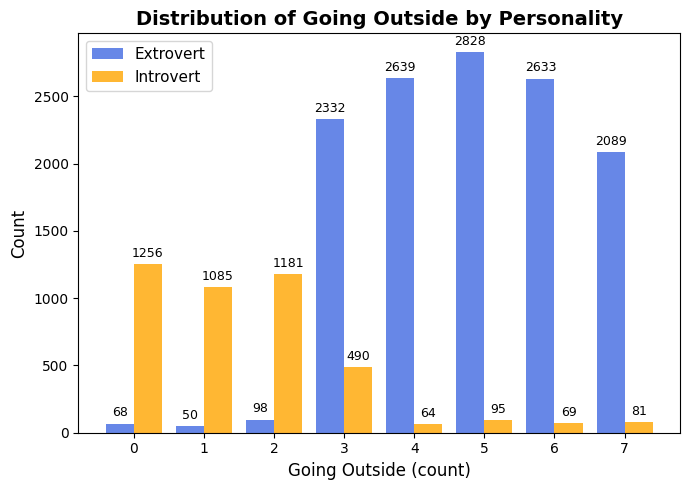

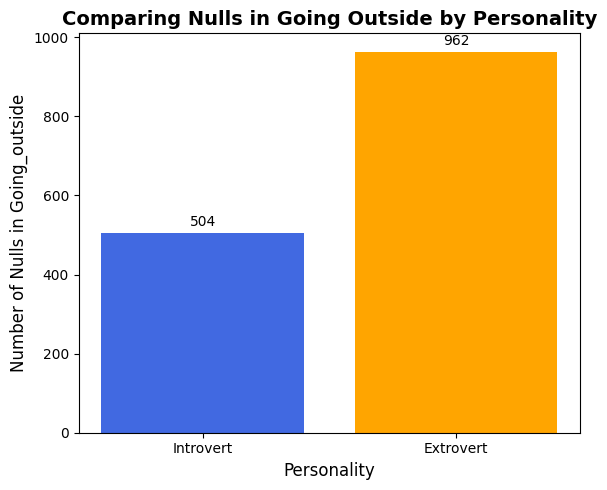

In [12]:
## VISUALIZATION 1: DISTRIBUTION OF GOING OUTSIDE
## -------------------------------------------------------------------------------------
# Dropping null values from Going_outside and converting to numpy array for plotting
going_outside = (
    df_train_raw
        .select("Going_outside")
        .drop_nulls()
        .to_numpy()
        .flatten()
)

# Plotting the histogram of Going_outside while ignoring nulls
fig, ax = plt.subplots(figsize = (7, 5))
ax.hist(going_outside, bins = 8, color = "skyblue", edgecolor = "black")
ax.set_xlabel("Going Outside (count)", fontsize = 12)
ax.set_ylabel("Frequency", fontsize = 12)
ax.set_title("Distribution of Going Outside", fontsize = 14, weight = "bold")
plt.tight_layout()
plt.show()



## VISUALIZATION 2: DISTRIBUTION OF GOING OUTSIDE BY PERSONALITY
## -------------------------------------------------------------------------------------
# Creating separate arrays for Going_outside by Personality
going_outside_extrovert = (
    df_train_raw
        .filter(pl.col("Personality") == "Extrovert")
        .select("Going_outside")
        .drop_nulls()
        .to_numpy()
        .flatten()
)
going_outside_introvert = (
    df_train_raw
        .filter(pl.col("Personality") == "Introvert")
        .select("Going_outside")
        .drop_nulls()
        .to_numpy()
        .flatten()
)

# Calculating the value counts for each integer value of Going_outside by Personality
extrovert_counts = np.bincount(going_outside_extrovert.astype(int), minlength = 8)
introvert_counts = np.bincount(going_outside_introvert.astype(int), minlength = 8)
x = np.arange(8)

# Creating a grouped bar plot to compare distributions
fig, ax = plt.subplots(figsize = (7, 5))
width = 0.4

# Plotting Extrovert bars
bars_extrovert = ax.bar(x - width / 2, extrovert_counts, width = width, label = "Extrovert", color = "royalblue", alpha = 0.8)

# Plotting Introvert bars
bars_introvert = ax.bar(x + width / 2, introvert_counts, width = width, label = "Introvert", color = "orange", alpha = 0.8)

# Adding count labels on each bar
for bar in bars_extrovert:
    height = bar.get_height()
    if height > 0:
        ax.annotate(f"{int(height)}",
                    xy = (bar.get_x() + bar.get_width() / 2, height),
                    xytext = (0, 3),
                    textcoords = "offset points",
                    ha = "center", va = "bottom", fontsize = 9)

for bar in bars_introvert:
    height = bar.get_height()
    if height > 0:
        ax.annotate(f"{int(height)}",
                    xy = (bar.get_x() + bar.get_width() / 2, height),
                    xytext = (0, 3),
                    textcoords = "offset points",
                    ha = "center", va = "bottom", fontsize = 9)

# Adding labels and title
ax.set_xlabel("Going Outside (count)", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Distribution of Going Outside by Personality", fontsize = 14, weight = "bold")
ax.set_xticks(x)
ax.legend(fontsize = 11)
plt.tight_layout()
plt.show()



## VISUALIZATION 3: COMPARING NULLS IN GOING OUTSIDE BY PERSONALITY
## -------------------------------------------------------------------------------------
# Calculating the number of nulls in Going_outside for each Personality
nulls_by_personality = (
    df_train_raw
        .select(["Personality", "Going_outside"])
        .with_columns(
            pl.col("Going_outside").is_null().alias("is_null")
        )
        .group_by("Personality")
        .agg(
            pl.col("is_null").sum().alias("num_nulls"),
            pl.len().alias("total")
        )
        .with_columns(
            (pl.col("num_nulls") / pl.col("total") * 100).alias("percent_nulls")
        )
        .to_pandas()
)

# Plotting the null counts as a bar chart
fig, ax = plt.subplots(figsize = (6, 5))
bars = ax.bar(
    nulls_by_personality["Personality"],
    nulls_by_personality["num_nulls"],
    color = ["royalblue", "orange"]
)

# Adding count labels on each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{int(height)}",
        xy = (bar.get_x() + bar.get_width() / 2, height),
        xytext = (0, 3),
        textcoords = "offset points",
        ha = "center", va = "bottom", fontsize = 10
    )

# Adding labels and title
ax.set_xlabel("Personality", fontsize = 12)
ax.set_ylabel("Number of Nulls in Going_outside", fontsize = 12)
ax.set_title("Comparing Nulls in Going Outside by Personality", fontsize = 14, weight = "bold")
plt.tight_layout()
plt.show()


#### Feature 5: `Drained_after_socializing`

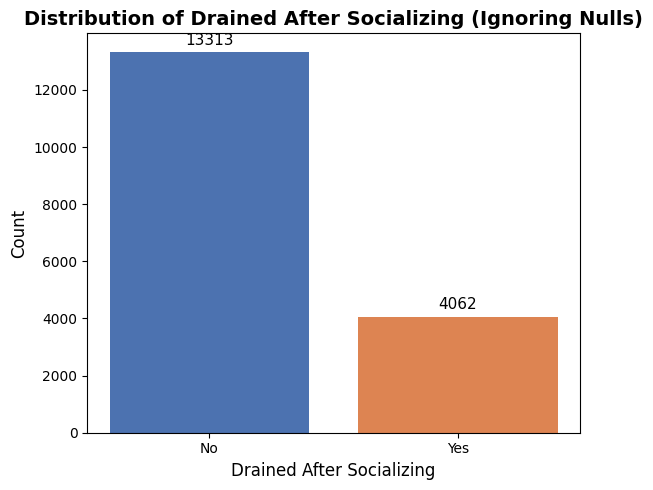

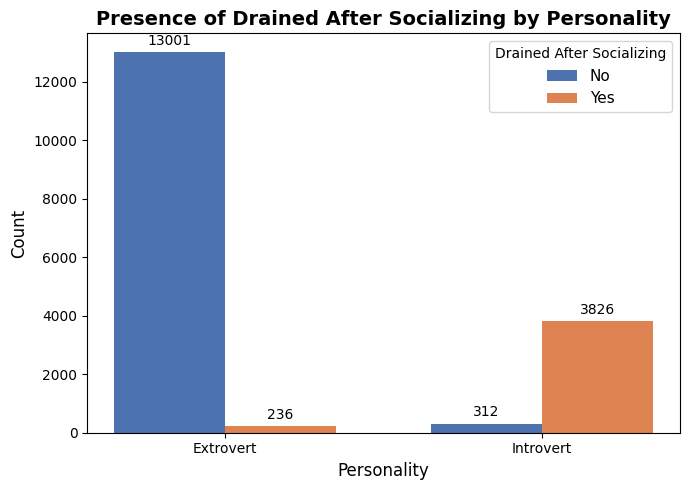

In [13]:
## VISUALIZATION 1: DISTRIBUTION OF DRAINED AFTER SOCIALIZING
## -------------------------------------------------------------------------------------
# Filtering out nulls from Drained_after_socializing and counting occurrences of "Yes" and "No"
drained_counts = (
    df_train_raw
        .filter(pl.col("Drained_after_socializing").is_not_null())
        .group_by("Drained_after_socializing")
        .len()
        .rename({"len": "count"})
        .sort("Drained_after_socializing")
        .to_pandas()
)

# Plotting the distribution of Drained_after_socializing values as a bar chart with different colors
fig, ax = plt.subplots(figsize = (6, 5))
bar_colors = ["#4C72B0", "#DD8452"]  # Assigning different colors for "No" and "Yes"
bars = ax.bar(
    drained_counts["Drained_after_socializing"],
    drained_counts["count"],
    color = bar_colors
)
ax.set_xlabel("Drained After Socializing", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Distribution of Drained After Socializing (Ignoring Nulls)", fontsize = 14, weight = "bold")
ax.bar_label(bars, padding = 3, fontsize = 11)
plt.tight_layout()
plt.show()


## VISUALIZATION 2: PRESENCE OF DRAINED AFTER SOCIALIZING BY PERSONALITY
## -------------------------------------------------------------------------------------
# Counting occurrences of Drained_after_socializing ("Yes"/"No") for each Personality
drained_by_personality = (
    df_train_raw
        .filter(pl.col("Drained_after_socializing").is_not_null())
        .group_by(["Personality", "Drained_after_socializing"])
        .len()
        .rename({"len": "count"})
        .sort(["Personality", "Drained_after_socializing"])
        .to_pandas()
)

# Pivoting the table for grouped bar plot
pivot = drained_by_personality.pivot(index = "Personality", columns = "Drained_after_socializing", values = "count").fillna(0)

# Plotting grouped bar chart
fig, ax = plt.subplots(figsize = (7, 5))
bar_width = 0.35
x = np.arange(len(pivot.index))

bars_no = ax.bar(x - bar_width / 2, pivot["No"], width = bar_width, label = "No", color = bar_colors[0])
bars_yes = ax.bar(x + bar_width / 2, pivot["Yes"], width = bar_width, label = "Yes", color = bar_colors[1])

# Adding count labels on each bar
for bars in [bars_no, bars_yes]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f"{int(height)}",
                        xy = (bar.get_x() + bar.get_width() / 2, height),
                        xytext = (0, 3),
                        textcoords = "offset points",
                        ha = "center", va = "bottom", fontsize = 10)

# Adding labels and title
ax.set_xlabel("Personality", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Presence of Drained After Socializing by Personality", fontsize = 14, weight = "bold")
ax.set_xticks(x)
ax.set_xticklabels(pivot.index)
ax.legend(title = "Drained After Socializing", fontsize = 11)
plt.tight_layout()
plt.show()


#### Feature 6: `Friends_circle_size`

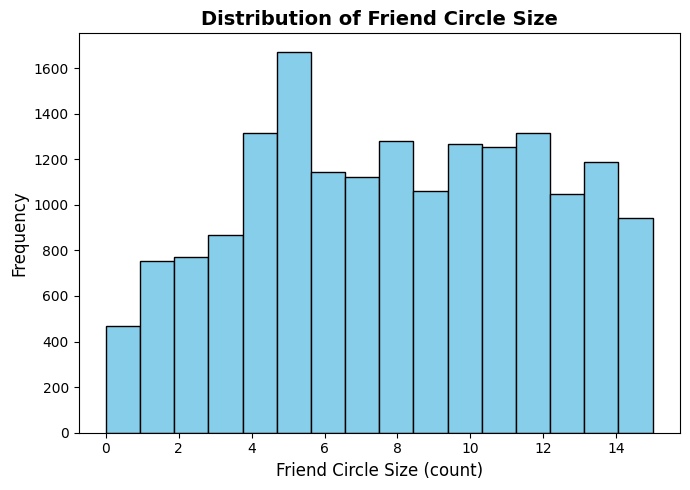

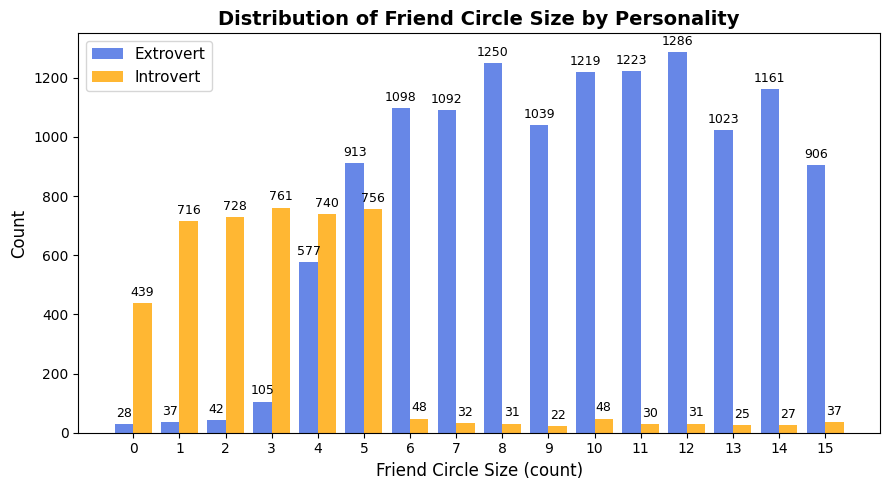

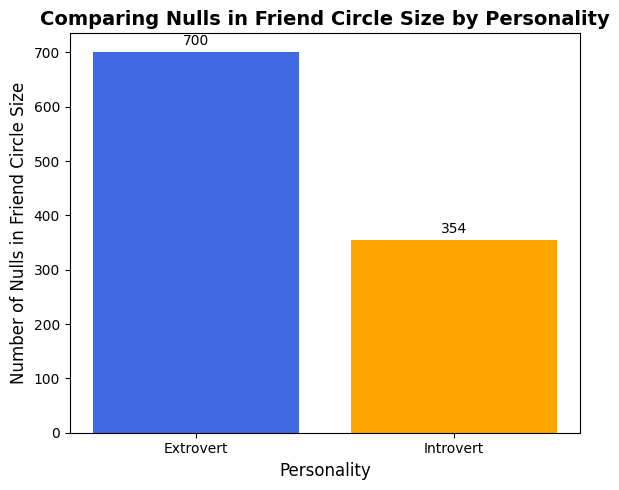

In [14]:
## VISUALIZATION 1: DISTRIBUTION OF FRIEND CIRCLE SIZE
## -------------------------------------------------------------------------------------
# Dropping null values from Friends_circle_size and converting to numpy array for plotting
friend_circle_size = (
    df_train_raw
        .select("Friends_circle_size")
        .drop_nulls()
        .to_numpy()
        .flatten()
)

# Plotting the histogram of Friends_circle_size while ignoring nulls
fig, ax = plt.subplots(figsize = (7, 5))
ax.hist(friend_circle_size, bins = 16, color = "skyblue", edgecolor = "black")
ax.set_xlabel("Friend Circle Size (count)", fontsize = 12)
ax.set_ylabel("Frequency", fontsize = 12)
ax.set_title("Distribution of Friend Circle Size", fontsize = 14, weight = "bold")
plt.tight_layout()
plt.show()



## VISUALIZATION 2: DISTRIBUTION OF FRIEND CIRCLE SIZE BY PERSONALITY
## -------------------------------------------------------------------------------------
# Creating separate arrays for Friends_circle_size by Personality
friend_circle_size_extrovert = (
    df_train_raw
        .filter(pl.col("Personality") == "Extrovert")
        .select("Friends_circle_size")
        .drop_nulls()
        .to_numpy()
        .flatten()
)
friend_circle_size_introvert = (
    df_train_raw
        .filter(pl.col("Personality") == "Introvert")
        .select("Friends_circle_size")
        .drop_nulls()
        .to_numpy()
        .flatten()
)

# Calculating the value counts for each integer value of Friends_circle_size by Personality
extrovert_counts = np.bincount(friend_circle_size_extrovert.astype(int), minlength = 16)
introvert_counts = np.bincount(friend_circle_size_introvert.astype(int), minlength = 16)
x = np.arange(16)

# Creating a grouped bar plot to compare distributions
fig, ax = plt.subplots(figsize = (9, 5))
width = 0.4

# Plotting Extrovert bars
bars_extrovert = ax.bar(x - width / 2, extrovert_counts, width = width, label = "Extrovert", color = "royalblue", alpha = 0.8)

# Plotting Introvert bars
bars_introvert = ax.bar(x + width / 2, introvert_counts, width = width, label = "Introvert", color = "orange", alpha = 0.8)

# Adding count labels on each bar
for bar in bars_extrovert:
    height = bar.get_height()
    if height > 0:
        ax.annotate(f"{int(height)}",
                    xy = (bar.get_x() + bar.get_width() / 2, height),
                    xytext = (0, 3),
                    textcoords = "offset points",
                    ha = "center", va = "bottom", fontsize = 9)

for bar in bars_introvert:
    height = bar.get_height()
    if height > 0:
        ax.annotate(f"{int(height)}",
                    xy = (bar.get_x() + bar.get_width() / 2, height),
                    xytext = (0, 3),
                    textcoords = "offset points",
                    ha = "center", va = "bottom", fontsize = 9)

# Adding labels and title
ax.set_xlabel("Friend Circle Size (count)", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Distribution of Friend Circle Size by Personality", fontsize = 14, weight = "bold")
ax.set_xticks(x)
ax.legend(fontsize = 11)
plt.tight_layout()
plt.show()



## VISUALIZATION 3: COMPARING NULLS IN FRIEND CIRCLE SIZE BY PERSONALITY
## -------------------------------------------------------------------------------------
# Calculating the number of nulls in Friends_circle_size for each Personality
nulls_by_personality = (
    df_train_raw
        .select(["Personality", "Friends_circle_size"])
        .with_columns(
            pl.col("Friends_circle_size").is_null().alias("is_null")
        )
        .group_by("Personality")
        .agg(
            pl.col("is_null").sum().alias("num_nulls"),
            pl.len().alias("total")
        )
        .with_columns(
            (pl.col("num_nulls") / pl.col("total") * 100).alias("percent_nulls")
        )
        .to_pandas()
)

# Plotting the null counts as a bar chart
fig, ax = plt.subplots(figsize = (6, 5))
bars = ax.bar(
    nulls_by_personality["Personality"],
    nulls_by_personality["num_nulls"],
    color = ["royalblue", "orange"]
)

# Adding count labels on each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{int(height)}",
        xy = (bar.get_x() + bar.get_width() / 2, height),
        xytext = (0, 3),
        textcoords = "offset points",
        ha = "center", va = "bottom", fontsize = 10
    )

# Adding labels and title
ax.set_xlabel("Personality", fontsize = 12)
ax.set_ylabel("Number of Nulls in Friend Circle Size", fontsize = 12)
ax.set_title("Comparing Nulls in Friend Circle Size by Personality", fontsize = 14, weight = "bold")
plt.tight_layout()
plt.show()


#### Feature 7: `Post_frequency`

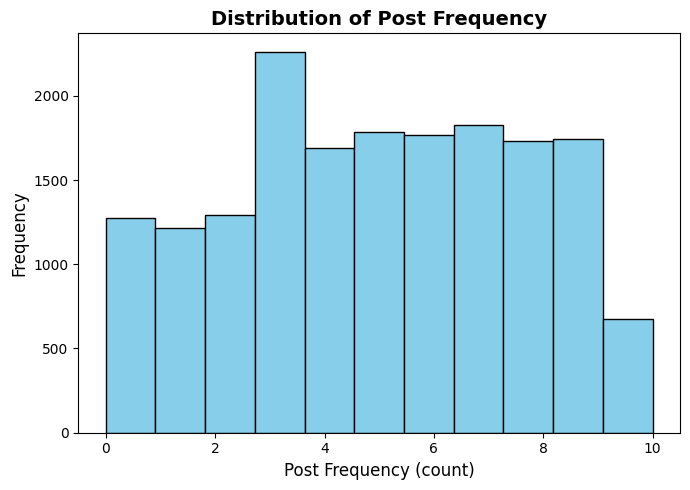

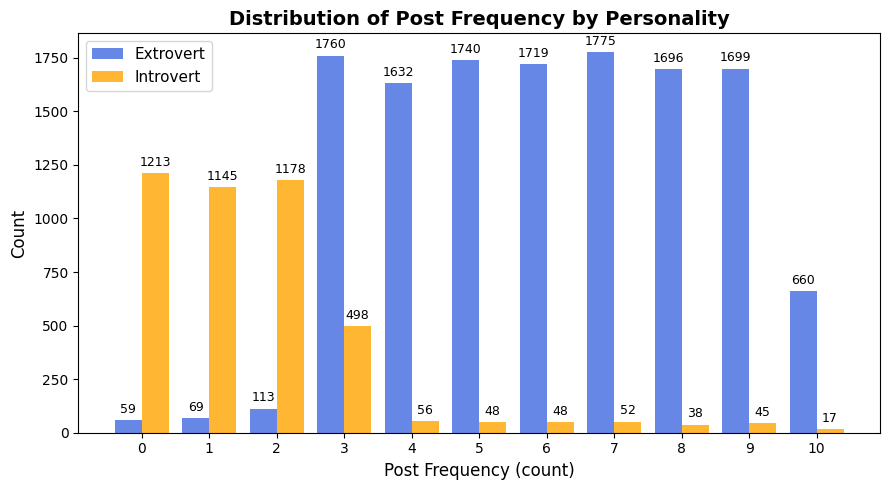

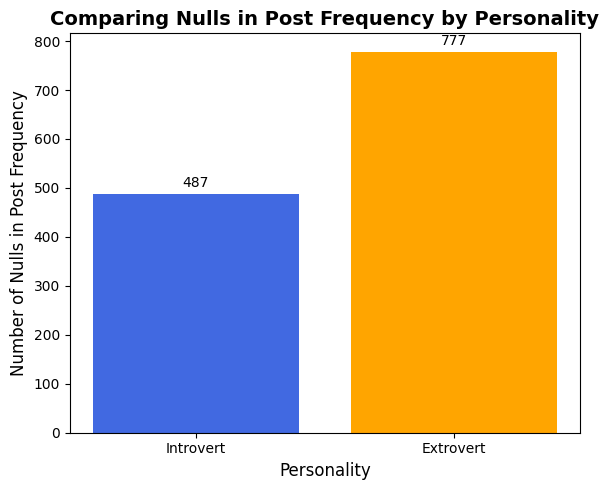

In [15]:
## VISUALIZATION 1: DISTRIBUTION OF POST FREQUENCY
## -------------------------------------------------------------------------------------
# Dropping null values from Post_frequency and converting to numpy array for plotting
post_frequency = (
    df_train_raw
        .select("Post_frequency")
        .drop_nulls()
        .to_numpy()
        .flatten()
)

# Plotting the histogram of Post_frequency while ignoring nulls
fig, ax = plt.subplots(figsize = (7, 5))
ax.hist(post_frequency, bins = 11, color = "skyblue", edgecolor = "black")
ax.set_xlabel("Post Frequency (count)", fontsize = 12)
ax.set_ylabel("Frequency", fontsize = 12)
ax.set_title("Distribution of Post Frequency", fontsize = 14, weight = "bold")
plt.tight_layout()
plt.show()


## VISUALIZATION 2: DISTRIBUTION OF POST FREQUENCY BY PERSONALITY
## -------------------------------------------------------------------------------------
# Creating separate arrays for Post_frequency by Personality
post_frequency_extrovert = (
    df_train_raw
        .filter(pl.col("Personality") == "Extrovert")
        .select("Post_frequency")
        .drop_nulls()
        .to_numpy()
        .flatten()
)
post_frequency_introvert = (
    df_train_raw
        .filter(pl.col("Personality") == "Introvert")
        .select("Post_frequency")
        .drop_nulls()
        .to_numpy()
        .flatten()
)

# Calculating the value counts for each integer value of Post_frequency by Personality
extrovert_counts = np.bincount(post_frequency_extrovert.astype(int), minlength = 11)
introvert_counts = np.bincount(post_frequency_introvert.astype(int), minlength = 11)
x = np.arange(11)

# Creating a grouped bar plot to compare distributions
fig, ax = plt.subplots(figsize = (9, 5))
width = 0.4

# Plotting Extrovert bars
bars_extrovert = ax.bar(x - width / 2, extrovert_counts, width = width, label = "Extrovert", color = "royalblue", alpha = 0.8)

# Plotting Introvert bars
bars_introvert = ax.bar(x + width / 2, introvert_counts, width = width, label = "Introvert", color = "orange", alpha = 0.8)

# Adding count labels on each bar
for bar in bars_extrovert:
    height = bar.get_height()
    if height > 0:
        ax.annotate(f"{int(height)}",
                    xy = (bar.get_x() + bar.get_width() / 2, height),
                    xytext = (0, 3),
                    textcoords = "offset points",
                    ha = "center", va = "bottom", fontsize = 9)

for bar in bars_introvert:
    height = bar.get_height()
    if height > 0:
        ax.annotate(f"{int(height)}",
                    xy = (bar.get_x() + bar.get_width() / 2, height),
                    xytext = (0, 3),
                    textcoords = "offset points",
                    ha = "center", va = "bottom", fontsize = 9)

# Adding labels and title
ax.set_xlabel("Post Frequency (count)", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Distribution of Post Frequency by Personality", fontsize = 14, weight = "bold")
ax.set_xticks(x)
ax.legend(fontsize = 11)
plt.tight_layout()
plt.show()


## VISUALIZATION 3: COMPARING NULLS IN POST FREQUENCY BY PERSONALITY
## -------------------------------------------------------------------------------------
# Calculating the number of nulls in Post_frequency for each Personality
nulls_by_personality = (
    df_train_raw
        .select(["Personality", "Post_frequency"])
        .with_columns(
            pl.col("Post_frequency").is_null().alias("is_null")
        )
        .group_by("Personality")
        .agg(
            pl.col("is_null").sum().alias("num_nulls"),
            pl.len().alias("total")
        )
        .with_columns(
            (pl.col("num_nulls") / pl.col("total") * 100).alias("percent_nulls")
        )
        .to_pandas()
)

# Plotting the null counts as a bar chart
fig, ax = plt.subplots(figsize = (6, 5))
bars = ax.bar(
    nulls_by_personality["Personality"],
    nulls_by_personality["num_nulls"],
    color = ["royalblue", "orange"]
)

# Adding count labels on each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{int(height)}",
        xy = (bar.get_x() + bar.get_width() / 2, height),
        xytext = (0, 3),
        textcoords = "offset points",
        ha = "center", va = "bottom", fontsize = 10
    )

# Adding labels and title
ax.set_xlabel("Personality", fontsize = 12)
ax.set_ylabel("Number of Nulls in Post Frequency", fontsize = 12)
ax.set_title("Comparing Nulls in Post Frequency by Personality", fontsize = 14, weight = "bold")
plt.tight_layout()
plt.show()


### Multivariate Analysis
Now that we've completed our univariate analysis, let's do some multivariate analysis.

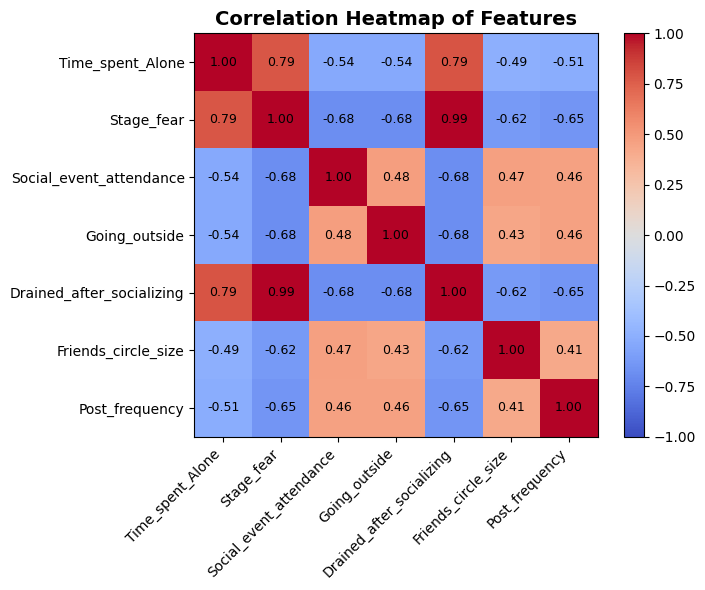

In [16]:
# Selecting only numeric columns except "id" and excluding nulls
# Converting "Stage_fear" and "Drained_after_socializing" to binary (Yes=1, No=0)
# Mapping "Yes" to 1 and "No" to 0 using replace for polars columns
df_corr = (
    df_train_raw
        .select([
            pl.col("Time_spent_Alone"),
            pl.col("Stage_fear").replace({"Yes": 1, "No": 0}).cast(pl.Int64),
            pl.col("Social_event_attendance"),
            pl.col("Going_outside"),
            pl.col("Drained_after_socializing").replace({"Yes": 1, "No": 0}).cast(pl.Int64),
            pl.col("Friends_circle_size"),
            pl.col("Post_frequency")
        ])
        .drop_nulls()
        .to_pandas()
)

# Calculating the correlation matrix
corr_matrix = df_corr.corr()

# Plotting the heatmap using matplotlib
fig, ax = plt.subplots(figsize = (8, 6))
im = ax.imshow(corr_matrix, cmap = "coolwarm", vmin = -1, vmax = 1)

# Adding feature names as ticks
feature_names = df_corr.columns
ax.set_xticks(np.arange(len(feature_names)))
ax.set_yticks(np.arange(len(feature_names)))
ax.set_xticklabels(feature_names, rotation = 45, ha = "right")
ax.set_yticklabels(feature_names)

# Adding correlation values on the heatmap
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha = "center", va = "center", color = "black", fontsize = 9)

# Adding colorbar and title
fig.colorbar(im, ax = ax, fraction = 0.046, pad = 0.04)
ax.set_title("Correlation Heatmap of Features", fontsize = 14, weight = "bold")
plt.tight_layout()
plt.show()

In [17]:
if RUN_CLUSTERING_VISUALIZATIONS:

    # Selecting numeric and binary-encoded features, dropping rows with nulls
    features = [
        "Time_spent_Alone",
        "Stage_fear",
        "Social_event_attendance",
        "Going_outside",
        "Drained_after_socializing",
        "Friends_circle_size",
        "Post_frequency"
    ]

    # Encoding "Yes"/"No" to 1/0 for binary features
    df_umap = (
        df_train_raw
            .select([
                pl.col("Time_spent_Alone"),
                pl.col("Stage_fear").replace({"Yes": 1, "No": 0}).cast(pl.Int64),
                pl.col("Social_event_attendance"),
                pl.col("Going_outside"),
                pl.col("Drained_after_socializing").replace({"Yes": 1, "No": 0}).cast(pl.Int64),
                pl.col("Friends_circle_size"),
                pl.col("Post_frequency"),
                pl.col("Personality")
            ])
            .drop_nulls()
            .to_pandas()
    )

    X = df_umap[features].values
    y = df_umap["Personality"].values

    # Creating UMAP embedding
    umap_embedder = umap.UMAP(random_state = 42)
    X_umap = umap_embedder.fit_transform(X)

    # Creating t-SNE embedding
    tsne_embedder = TSNE(n_components = 2, random_state = 42, perplexity = 30)
    X_tsne = tsne_embedder.fit_transform(X)

    # Plotting UMAP
    fig, ax = plt.subplots(1, 2, figsize = (14, 6))
    for label, color in zip(["Extrovert", "Introvert"], ["royalblue", "orange"]):
        idx = y == label
        ax[0].scatter(X_umap[idx, 0], X_umap[idx, 1], label = label, alpha = 0.5, s = 15, color = color)
    ax[0].set_title("UMAP Projection", fontsize = 14, weight = "bold")
    ax[0].set_xlabel("UMAP 1")
    ax[0].set_ylabel("UMAP 2")
    ax[0].legend()

    # Plotting t-SNE
    for label, color in zip(["Extrovert", "Introvert"], ["royalblue", "orange"]):
        idx = y == label
        ax[1].scatter(X_tsne[idx, 0], X_tsne[idx, 1], label = label, alpha = 0.5, s = 15, color = color)
    ax[1].set_title("t-SNE Projection", fontsize = 14, weight = "bold")
    ax[1].set_xlabel("t-SNE 1")
    ax[1].set_ylabel("t-SNE 2")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

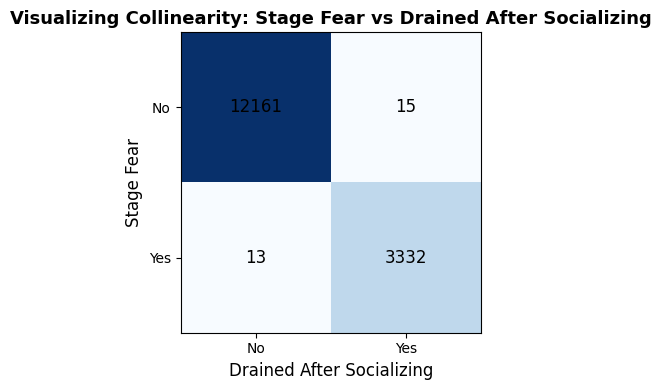

In [18]:
# Filtering out rows where either "Stage_fear" or "Drained_after_socializing" is null
df_stage_drained = (
    df_train_raw
        .filter(
            pl.col("Stage_fear").is_not_null() & pl.col("Drained_after_socializing").is_not_null()
        )
        .select(["Stage_fear", "Drained_after_socializing"])
        .to_pandas()
)

# Creating a crosstab to count occurrences of each combination
crosstab = pd.crosstab(
    df_stage_drained["Stage_fear"],
    df_stage_drained["Drained_after_socializing"]
)

# Plotting the heatmap of the crosstab
fig, ax = plt.subplots(figsize = (5, 4))
im = ax.imshow(crosstab.values, cmap = "Blues")

# Adding axis labels and title
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(crosstab.columns)
ax.set_yticklabels(crosstab.index)
ax.set_xlabel("Drained After Socializing", fontsize = 12)
ax.set_ylabel("Stage Fear", fontsize = 12)
ax.set_title("Visualizing Collinearity: Stage Fear vs Drained After Socializing", fontsize = 13, weight = "bold")

# Adding count annotations
for i in range(crosstab.shape[0]):
    for j in range(crosstab.shape[1]):
        ax.text(j, i, crosstab.values[i, j], ha = "center", va = "center", color = "black", fontsize = 12)

plt.tight_layout()
plt.show()

### Exploratory Data Analysis Summary
Now that we've completed our EDA, let's make some notes summarizing our findings:

- **Target class imbalance**: This training dataset features a pretty heavy target class imbalance, where 74% of the target class is represented by extroverts. Generally speaking, I would be concerned with things like subsetting or another tactic to balance the number of records with a more evenly split target class, but I'm not so sure that I'm super concerned with that given the other bullets here.
- **Generally clear delineation between introverts and extroverts**: As we saw in our univariate section, you could generally draw a clear line between introverts and extroverts.
- **Dealing with the small set of ambiverts**: If you are not familiar with the term, *ambivert* is the formal term that is used to describe somebody who exhibits balanced introverted and extroverted attributes. Though there is a general split between extroverts and introverts, there is this small subset in the middle that I would consider more so to be ambiverts.
- **Null values**: There are quite a few null values across all the features of the dataset. Unfortunately, they're not particularly uniform, meaning that we can't simply drop records that may be more notorious for containing more null values.
- **Multicollinearity between `Stage_fear` and `Drained_after_socializing`**: As evidenced by the heatmap, these features are extremely highly correlated. We need to be specifcially careful of this if we choose to use any regression-based models, like logistic regression.

## Feature Engineering
Now that we've completed our EDA, let's move into performing our feature engineering. Before we jump into the code, let's lay out what are intentions are for this section:

- **Range-based binning**: For each of our range-based features, our univariate analysis informed us that we can, for the most part, comfortably bin the data into introvert, ambivert, and extrovert bins. Because I'm not sure a cleaner way to do this in a quick turnaround timeframe, I am going to hard code what the values for each of these bins should be per their respective features. We will still keep the original features around but also add these new "grouping" features to represent the bins. 
- **Null handling**: We're going to need to take care of all the nulls in this dataset. There's not a particularly "one size fits all" answer here, so we will use our univariate analysis to help guide us here. To be clear, some of our null handling tactics would make several uncomfortable because they are more so assumptions based on the data itself. It is important to recognize two things here: a) we are working with a limited dataset and b) we are working within the context of a Kaggle competition. In the "real world", you'll want to be careful not to make these narrow assumptions. Generally speaking, here is how we will handle the nulls:
    - **"Yes" / "No" features**: Determine the introvert / ambivert / extrovert grouping using other non-null features. Once determined, assign an appropriate "Yes" / "No" label for the respective introvert / extrovert. For ambiverts or other edge cases, automatically assign the extrovert's general "Yes" / "No" label.
    - **Range-based numerical features**: Determine the introvert / ambivert / extrovert grouping using other non-null features. Once determined, assigned the median value associated to that introvert / ambivert / extrovert grouping. In edge cases where a grouping cannot be determined, automatically assign the median value associated to the extrovert's grouping.
- **One-hot encoding label-based features**: After we have created all our label-based features (including the 2 binary "Yes" / "No" features), we will need to perform an appropriate one-hot encoding.
- **Target variable encoding**: The current target variable, `Personality`, is comprised of labeled values of either "Introvert" or "Extrovert". We need to respectively encode these to 0 or 1.
- **(Optinonal) Data scaling**: Depending on the ML algorithm we choose to test, we may need to do a scaling of the data.
- **(Optional) Collinear feature removal**: Depending on the ML algorithm we choose to test, we may need to remove one of the collinear features (`Stage_fear` or `Drained_after_socializing`).

### Range-Based Binning

In [19]:
# Setting a dictionary to hold range-based feature groupings
RANGE_FEAT_GROUPS = {
    "Time_spent_Alone": {
        "introvert": [5, 6, 7, 8, 9, 10, 11],
        "ambivert": [4],
        "extrovert": [0, 1, 2, 3]
    },
    "Social_event_attendance": {
        "introvert": [0, 1, 2],
        "ambivert": [3],
        "extrovert": [4, 5, 6, 7, 8, 9, 10]
    },
    "Going_outside": {
        "introvert": [0, 1, 2],
        "ambivert": [3],
        "extrovert": [4, 5, 6, 7]
    },
    "Friends_circle_size": {
        "introvert": [0, 1, 2, 3],
        "ambivert": [4, 5],
        "extrovert": [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    },
    "Post_frequency": {
        "introvert": [0, 1, 2],
        "ambivert": [3],
        "extrovert": [4, 5, 6, 7, 8, 9, 10]
    }
}

# Setting a list of the binary features
BINARY_FEATS = [
    "Stage_fear",
    "Drained_after_socializing"
]

In [20]:
# Adding group labels for each feature in RANGE_FEAT_GROUPS to df_train_raw
for feat, groupings in RANGE_FEAT_GROUPS.items():
    
    # Creating a new column name for the group label
    group_col = f"{feat}_group"
    # Defining a function to assign group label based on value
    def assign_group(val):
        if val is None:
            return None
        for group, values in groupings.items():
            if val in values:
                return group
        return None
    
    # Adding the new group label column using pl.map_elements for element-wise mapping
    df_train_raw = df_train_raw.with_columns(
        pl.col(feat).map_elements(assign_group).alias(group_col)
    )

### Null Handling
Pretty much all our features have some amount of nulls in them. Because this dataset is so cut and dry, the way we're going to handle these nulls is basically by looking at how all the other non-null features are leaning.

In [21]:
# Instantiating a dictionary to hold the median values for each feature and personality group
range_feat_medians = {}

# Iterating over feature and groupings pairs in RANGE_FEAT_GROUPS
for feat, groupings in RANGE_FEAT_GROUPS.items():

    # Initializing a sub-dictionary for the current feature
    range_feat_medians[feat] = {}
    
    # Iterating over the personality group and their corresponding value ranges
    for group, values in groupings.items():

        # Calculating the median for the current feature and group, excluding nulls
        median_val = (
            df_train_raw
                .filter(pl.col(feat).is_in(values))
                .select(pl.col(feat).median())
                .item()
        )
        
        # Storing the calculated median
        range_feat_medians[feat][group] = median_val

# Saving the range_feat_medians dictionary to a JSON file
with open("data/other/medians.json", "w") as f:
    json.dump(range_feat_medians, f, indent = 4)

In [22]:
# Iterating over each feature in RANGE_FEAT_GROUPS to fill null values
for feat, groupings in RANGE_FEAT_GROUPS.items():

    # Setting the group column name
    group_col = f"{feat}_group"

    # Defining a function to determine the most common group label for a row
    def get_most_common_group(row):
        # Collecting group labels from other features for the current row
        other_group_labels = [
            row[f"{other_feat}_group"]
            for other_feat in RANGE_FEAT_GROUPS
            if other_feat != feat and row[f"{other_feat}_group"] is not None
        ]
        # Determining the most common group, defaulting to "extrovert"
        if other_group_labels:
            most_common_label = Counter(other_group_labels).most_common(1)[0][0]
        else:
            most_common_label = "extrovert"
        return most_common_label

    # Creating a DataFrame with the group columns for all features
    group_cols = [f"{other_feat}_group" for other_feat in RANGE_FEAT_GROUPS]
    group_df = df_train_raw.select(group_cols).to_dicts()

    # Calculating the most common group for each row
    most_common_groups = [get_most_common_group(row) for row in group_df]

    # Defining a function to get the median value based on the most common group
    def get_median_value(group):
        return range_feat_medians[feat].get(group, range_feat_medians[feat]["extrovert"])

    # Calculating the median values for filling nulls
    median_values = [get_median_value(group) for group in most_common_groups]

    # Adding the filled columns to a new DataFrame df_train instead of overwriting df_train_raw
    if 'df_train' not in locals():
        df_train = df_train_raw.clone()
    df_train = df_train.with_columns(
        pl.when(pl.col(feat).is_null())
          .then(pl.Series(median_values))
          .otherwise(pl.col(feat))
          .alias(feat),
        pl.when(pl.col(group_col).is_null())
          .then(pl.Series(most_common_groups))
          .otherwise(pl.col(group_col))
          .alias(group_col)
    )


In [23]:
# Iterating over the binary features to handle null values
for feat in BINARY_FEATS:

    # Determining the other binary feature
    other_feat = next(f for f in BINARY_FEATS if f != feat)

    # Defining a function to determine the most common group label for a row
    def get_most_common_group(row):
        
        # Collecting group labels from all range features for the current row
        group_labels = [
            row[f"{f}_group"]
            for f in RANGE_FEAT_GROUPS
            if row[f"{f}_group"] is not None
        ]
        # Determining the most common group, defaulting to "extrovert"
        if group_labels:
            most_common_label = Counter(group_labels).most_common(1)[0][0]
        else:
            most_common_label = "extrovert"
        return most_common_label

    # Creating a DataFrame with all the group columns
    group_cols = [f"{f}_group" for f in RANGE_FEAT_GROUPS]
    group_df = df_train.select(group_cols).to_dicts()

    # Calculating the most common group for each row
    most_common_groups = pl.Series("most_common_group", [get_most_common_group(row) for row in group_df])

    # Defining the fill value based on the most common group
    # If introvert -> "Yes", otherwise ("extrovert", "ambivert") -> "No"
    fill_value = pl.when(most_common_groups == "introvert").then(pl.lit("Yes")).otherwise(pl.lit("No"))

    # Applying the logic to fill nulls in the current binary feature
    df_train = df_train.with_columns(
        pl.when(pl.col(feat).is_null())
          .then(
              # If the other feature is not null, use its value
              pl.when(pl.col(other_feat).is_not_null())
                .then(pl.col(other_feat))
                # Otherwise, use the value based on the most common group
                .otherwise(fill_value)
          )
          .otherwise(pl.col(feat))
          .alias(feat)
    )

### One Hot Encoding

In [24]:
# Collecting all group label columns
group_label_cols = [f"{feat}_group" for feat in RANGE_FEAT_GROUPS]

# Collecting all binary feature columns
binary_label_cols = BINARY_FEATS

# Defining all label-based columns to encode
label_cols = group_label_cols + binary_label_cols

# Defining all possible categories for group and binary features
group_categories = ["introvert", "ambivert", "extrovert"]
binary_categories = ["Yes", "No"]

# Creating one-hot encoded columns for each label-based feature
for col in label_cols:

    # Determining categories for the current column
    categories = group_categories if col in group_label_cols else binary_categories
    
    # Adding one-hot columns for each category
    for cat in categories:
        df_train = df_train.with_columns(
            (pl.col(col) == cat).cast(pl.Int8).alias(f"{col}__{cat}")
        )
        
    # Removing the original label-based column after encoding
    df_train = df_train.drop(col)

### Target Variable Encoding

In [25]:
# Encoding the Personality feature: mapping "Introvert" to 0 and "Extrovert" to 1 in place
df_train = df_train.with_columns(
    pl.col("Personality").map_elements(lambda x: 0 if x == "Introvert" else 1).alias("Personality")
)

### Engineering for Logistic Regression
By this point in our feature engineering section, `df_train` is pretty much ready to go for most of the machine learning algorithms we'll be testing. We will, however, be testing the **logistic regression** algorithm, which is sensitive to both *data scaling* and *multicollinearity*.

In [26]:
# Creating a new version of df_train for logistic regression while dropping the multicollinear features
cols_to_drop = [col for col in ["Stage_fear", "Stage_fear_group"] if col in df_train.columns]
df_train_lr = df_train.drop(cols_to_drop)

# Identifying range-based features to scale (excluding "id" and "Personality")
range_feats = list(RANGE_FEAT_GROUPS.keys())

# Creating a StandardScaler instance
scaler = StandardScaler()

# Fitting and transforming the range-based features
scaled_values = scaler.fit_transform(df_train_lr.select(range_feats).to_numpy())

# Creating a new DataFrame with scaled values and original column names
scaled_df = pl.DataFrame(scaled_values, schema = range_feats)

# Replacing the original range-based columns with the scaled columns in df_train_lr
df_train_lr = df_train_lr.with_columns([scaled_df[col].alias(col) for col in range_feats])

### Hardening the Feature Engineering Code
Now that we've effectively completed our feature engineering code, we're going to use this section to harden it specifically for usage within a Scikit-Learn `Pipeline`. This will help streamline our code going forward.

In [27]:
# Setting a dictionary to hold range-based feature groupings
RANGE_FEAT_GROUPS = {
    "Time_spent_Alone": {
        "introvert": [5, 6, 7, 8, 9, 10, 11],
        "ambivert": [4],
        "extrovert": [0, 1, 2, 3]
    },
    "Social_event_attendance": {
        "introvert": [0, 1, 2],
        "ambivert": [3],
        "extrovert": [4, 5, 6, 7, 8, 9, 10]
    },
    "Going_outside": {
        "introvert": [0, 1, 2],
        "ambivert": [3],
        "extrovert": [4, 5, 6, 7]
    },
    "Friends_circle_size": {
        "introvert": [0, 1, 2, 3],
        "ambivert": [4, 5],
        "extrovert": [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    },
    "Post_frequency": {
        "introvert": [0, 1, 2],
        "ambivert": [3],
        "extrovert": [4, 5, 6, 7, 8, 9, 10]
    }
}

# Setting a list of the binary features
BINARY_FEATS = [
    "Stage_fear",
    "Drained_after_socializing"
]

# Loading the range_feat_medians dictionary from the JSON file
with open("data/other/medians.json", "r") as f:
    range_feat_medians = json.load(f)

In [28]:
# Creating a custom transformer for feature engineering
class FeatureEngineering(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.range_feat_groups = RANGE_FEAT_GROUPS
        self.binary_feats = BINARY_FEATS
        self.range_feat_medians = range_feat_medians

    def fit(self, X, y=None):
        # No fitting necessary for this transformer
        return self
    
    def transform(self, df):
        # Cloning the DataFrame to avoid modifying the original
        df = df.clone()

        ## ADDING GROUP LABELS FOR RANGE-BASED FEATURES
        ## -------------------------------------------------------------------------------------
        # Adding group labels for each feature in RANGE_FEAT_GROUPS to df
        for feat, groupings in self.range_feat_groups.items():
            
            # Creating a new column name for the group label
            group_col = f"{feat}_group"
            
            # Creating a mapping expression for groups
            mapping_expr = pl.when(pl.col(feat).is_in(groupings["introvert"])).then(pl.lit("introvert")) \
                             .when(pl.col(feat).is_in(groupings["ambivert"])).then(pl.lit("ambivert")) \
                             .when(pl.col(feat).is_in(groupings["extrovert"])).then(pl.lit("extrovert")) \
                             .otherwise(None)
            
            # Adding the new group label column
            df = df.with_columns(
                mapping_expr.alias(group_col)
            )

        ## FILLING NULLS IN RANGE-BASED FEATURES
        ## -------------------------------------------------------------------------------------
        # Iterating over each feature in RANGE_FEAT_GROUPS to fill null values
        for feat in self.range_feat_groups:
            group_col = f"{feat}_group"
            other_group_cols = [f"{other_feat}_group" for other_feat in self.range_feat_groups if other_feat != feat]

            # Calculating the most common group label across other features for each row
            most_common_group_expr = pl.concat_list(other_group_cols).list.eval(pl.element().mode()).list.get(0).fill_null("extrovert")

            # Creating a mapping for median values based on group labels
            median_map = self.range_feat_medians[feat]
            median_fill_expr = pl.when(most_common_group_expr == "introvert").then(median_map.get("introvert")) \
                                 .when(most_common_group_expr == "ambivert").then(median_map.get("ambivert")) \
                                 .otherwise(median_map.get("extrovert"))

            # Filling nulls in the feature and its group column
            df = df.with_columns(
                pl.col(feat).fill_null(median_fill_expr).alias(feat),
                pl.col(group_col).fill_null(most_common_group_expr).alias(group_col)
            )

        ## FILLING NULLS IN BINARY FEATURES
        ## -------------------------------------------------------------------------------------
        # Calculating the most common group label across all range features for each row
        all_group_cols = [f"{f}_group" for f in self.range_feat_groups]
        most_common_overall_group = pl.concat_list(all_group_cols).list.eval(pl.element().mode()).list.get(0).fill_null("extrovert")
        
        # Defining the fill value based on the most common group
        fill_value = pl.when(most_common_overall_group == "introvert").then(pl.lit("Yes")).otherwise(pl.lit("No"))

        # Iterating over the binary features to handle null values
        for feat in self.binary_feats:
            other_feat = next(f for f in self.binary_feats if f != feat)
            
            # Applying the logic to fill nulls in the current binary feature
            df = df.with_columns(
                pl.when(pl.col(feat).is_null())
                .then(
                    pl.col(other_feat).fill_null(fill_value)
                )
                .otherwise(pl.col(feat))
                .alias(feat)
            )

        ## ONE-HOT ENCODING LABEL-BASED FEATURES
        ## -------------------------------------------------------------------------------------
        # Collecting all group label columns
        group_label_cols = [f"{feat}_group" for feat in self.range_feat_groups]

        # Collecting all binary feature columns
        binary_label_cols = self.binary_feats

        # Defining all label-based columns to encode
        label_cols = group_label_cols + binary_label_cols

        # One-hot encoding the label-based columns
        df = df.to_dummies(columns = label_cols)

        return df
            

# Creating a column transformer to scale only range-based features
lr_extra_transformer = ColumnTransformer(
    transformers = [
        ("range_scaler", StandardScaler(), list(RANGE_FEAT_GROUPS.keys())),
        ('drop', 'drop', ['Stage_fear_Yes', 'Stage_fear_No'])
    ],
    remainder = "passthrough"
).set_output(transform = "polars")

In [29]:
# Intializing a Pipeline with FeatureEngineering
pipeline = Pipeline([
    ("feature_engineering", FeatureEngineering())
])


# Initializing a Pipeline with FeatureEngineering and scaling transformer
pipeline_lr = Pipeline([
    ("feature_engineering", FeatureEngineering()),
    ("lr_extra_transformer", lr_extra_transformer),
])

### Final Testing of the Hardened Feature Engineering

In [30]:
# Reading the raw test data
X_raw = pl.read_csv('data/raw/test.csv')
X_raw = X_raw.drop(["id"])

# Fitting and transforming the data
X = pipeline.fit_transform(X_raw)

# Fitting and transforming the data (for logistic regression)
X_lr = pipeline_lr.fit_transform(X_raw)

In [31]:
# Reading the raw training data
X_raw = pl.read_csv('data/raw/train.csv')
X_raw = X_raw.with_columns(
    pl.col("Personality").map_elements(lambda x: 0 if x == "Introvert" else 1).alias("Personality")
)
y = X_raw.select("Personality")
X_raw = X_raw.drop(["id", "Personality"])

# Fitting and transforming the data
X = pipeline.fit_transform(X_raw)

# Fitting and transforming the data (for logistic regression)
X_lr = pipeline_lr.fit_transform(X_raw)

## Model Selection
Now that we have completed our feature engineering, we're ready to explore some various candidate algorithms to use as our final model submission. If you are not aware, there are many different algorithms that support various forms of machine learning. In our case, we are working with a **binary classification** problem, so we will need to focus in on binary classification algorithms. There are many different algorithms we could select from, but to keep ourselves limited, we're going to focus in on the following algorithms:

- **RandomForestClassifier**: An ensemble method that builds multiple decision trees and merges their results for more accurate and stable predictions. Random forests are robust to overfitting, handle both numerical and categorical data well, and are not sensitive to data scaling. They are effective for datasets with complex, non-linear relationships and can provide feature importance scores.
- **XGBoost**: A highly efficient and scalable implementation of gradient boosting for decision trees. XGBoost is known for its performance in structured/tabular data and competitions. It is robust to outliers, handles missing values internally, and is not sensitive to data scaling. It is particularly good for capturing complex patterns and interactions in the data.
- **Logistic Regression**: A linear model used for binary classification tasks. Logistic regression is easy to interpret and works well when the relationship between features and the target is approximately linear. It is sensitive to data scaling, so features should be standardized or normalized. It can be affected by multicollinearity among features.
- **Support Vector Machine (SVM)**: A powerful classifier that finds the optimal hyperplane to separate classes, with options for linear and non-linear boundaries using kernels. SVMs are effective for high-dimensional spaces and can model complex boundaries. They are sensitive to data scaling, so feature standardization is important. SVMs can be computationally intensive for large datasets.
- **Decision Tree**: A simple, interpretable model that splits data into branches based on feature values. Decision trees can capture non-linear relationships and are not sensitive to data scaling. However, they are prone to overfitting, especially with deep trees, and may not generalize well without pruning or ensemble methods.

### Hyperparameter Tuning
Hyperparameter tuning is the process of systematically searching for the best combination of model parameters that are not learned directly from the data, but instead control the learning process itself (such as tree depth, learning rate, or regularization strength). Selecting optimal hyperparameters is crucial because it can significantly improve model performance, prevent overfitting, and ensure that the model generalizes well to unseen data.

Because we are working with a relatively small dataset, it is especially important to make the most of our available data while still obtaining reliable validation results. To achieve this, we are using **a stratified KFold (`StratifiedKFold`) cross-validation** within the Optuna hyperparameter optimization process. StratifiedKFold ensures that each fold maintains the same proportion of target classes as the full dataset, providing a more robust and unbiased estimate of model performance during tuning. This approach helps us avoid overfitting to a particular train/validation split and makes our hyperparameter search more reliable.

In [32]:
# Defining Optuna objective functions for each model
def objective_xgb(trial):
    param = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": "gbtree",
        "tree_method": "hist",
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log = True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log = True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log = True),
    }
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    aucs = []
    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model = xgb.XGBClassifier(**param)
        model.fit(X_tr, y_tr, eval_set = [(X_val, y_val)], verbose = 0)
        preds = model.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, preds))
    return np.mean(aucs)

def objective_rf(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "random_state": 42,
        "n_jobs": -1,
    }
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    aucs = []
    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model = RandomForestClassifier(**param)
        model.fit(X_tr, y_tr)
        preds = model.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, preds))
    return np.mean(aucs)

def objective_dt(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "random_state": 42,
    }
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    aucs = []
    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model = DecisionTreeClassifier(**param)
        model.fit(X_tr, y_tr)
        preds = model.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, preds))
    return np.mean(aucs)

def objective_lr(trial):
    # Mapping Optuna's 'none' to None for scikit-learn compatibility
    penalty_choice = trial.suggest_categorical("penalty", ["l2", None])
    param = {
        "C": trial.suggest_float("C", 1e-3, 10.0, log = True),
        "penalty": penalty_choice,
        "solver": "lbfgs",
        "random_state": 42,
        "max_iter": 1000,
    }
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    aucs = []
    for train_idx, valid_idx in skf.split(X_lr_train, y_lr_train):
        X_tr, X_val = X_lr_train.iloc[train_idx], X_lr_train.iloc[valid_idx]
        y_tr, y_val = y_lr_train.iloc[train_idx], y_lr_train.iloc[valid_idx]
        model = LogisticRegression(**param)
        model.fit(X_tr, y_tr)
        preds = model.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, preds))
    return np.mean(aucs)

def objective_svc(trial):
    param = {
        "C": trial.suggest_float("C", 1e-3, 10.0, log = True),
        "kernel": trial.suggest_categorical("kernel", ["rbf", "linear", "poly"]),
        "probability": True,
        "random_state": 42,
    }
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    aucs = []
    for train_idx, valid_idx in skf.split(X_lr_train, y_lr_train):
        X_tr, X_val = X_lr_train.iloc[train_idx], X_lr_train.iloc[valid_idx]
        y_tr, y_val = y_lr_train.iloc[train_idx], y_lr_train.iloc[valid_idx]
        model = SVC(**param)
        model.fit(X_tr, y_tr)
        preds = model.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, preds))
    return np.mean(aucs)


In [33]:
# Splitting data for tree-based models (X, y)
X_pd = X.to_pandas()
y_pd = y.to_pandas().squeeze()
X_train, X_test, y_train, y_test = train_test_split(
    X_pd, y_pd, test_size = 0.2, random_state = 42, stratify = y_pd
)

# Splitting data for scaling-sensitive models (X_lr, y)
X_lr_pd = X_lr.to_pandas()
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(
    X_lr_pd, y_pd, test_size = 0.2, random_state = 42, stratify = y_pd
)

In [34]:
# Running Optuna hyperparameter tuning if the flag is set
if RUN_OPTUNA_HYPERPARAMETER_TUNING:

    # XGBoost
    xgb_params_path = "data/other/xgb_best_params.json"
    if not os.path.exists(xgb_params_path):
        study_xgb = optuna.create_study(direction = "maximize", study_name = "xgboost_auc")
        study_xgb.optimize(objective_xgb, n_trials = 30, timeout = 600)
        # Saving best XGBoost params immediately after optimization
        with open(xgb_params_path, "w") as f:
            json.dump(study_xgb.best_params, f, indent = 4)
    else:
        print("Skipping XGBoost Optuna: params already exist.")

    # RandomForest
    rf_params_path = "data/other/rf_best_params.json"
    if not os.path.exists(rf_params_path):
        study_rf = optuna.create_study(direction = "maximize", study_name = "rf_auc")
        study_rf.optimize(objective_rf, n_trials = 30, timeout = 600)
        # Saving best RandomForest params immediately after optimization
        with open(rf_params_path, "w") as f:
            json.dump(study_rf.best_params, f, indent = 4)
    else:
        print("Skipping RandomForest Optuna: params already exist.")

    # DecisionTree
    dt_params_path = "data/other/dt_best_params.json"
    if not os.path.exists(dt_params_path):
        study_dt = optuna.create_study(direction = "maximize", study_name = "dt_auc")
        study_dt.optimize(objective_dt, n_trials = 30, timeout = 600)
        # Saving best DecisionTree params immediately after optimization
        with open(dt_params_path, "w") as f:
            json.dump(study_dt.best_params, f, indent = 4)
    else:
        print("Skipping DecisionTree Optuna: params already exist.")

    # Logistic Regression
    lr_params_path = "data/other/lr_best_params.json"
    if not os.path.exists(lr_params_path):
        study_lr = optuna.create_study(direction = "maximize", study_name = "lr_auc")
        study_lr.optimize(objective_lr, n_trials = 30, timeout = 600)
        # Saving best LogisticRegression params immediately after optimization
        with open(lr_params_path, "w") as f:
            json.dump(study_lr.best_params, f, indent = 4)
    else:
        print("Skipping LogisticRegression Optuna: params already exist.")

    # SVC
    svc_params_path = "data/other/svc_best_params.json"
    if not os.path.exists(svc_params_path):
        study_svc = optuna.create_study(direction = "maximize", study_name = "svc_auc")
        study_svc.optimize(objective_svc, n_trials = 30, timeout = 600)
        # Saving best SVC params immediately after optimization
        with open(svc_params_path, "w") as f:
            json.dump(study_svc.best_params, f, indent = 4)
    else:
        print("Skipping SVC Optuna: params already exist.")

    # Training and evaluating the best models
    best_models = {}

    # XGBoost
    xgb_params = study_xgb.best_params
    xgb_params.update({
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": "gbtree",
        "tree_method": "hist",
        "random_state": 42,
    })
    final_xgb = xgb.XGBClassifier(**xgb_params)
    final_xgb.fit(X_train, y_train)
    y_pred = final_xgb.predict(X_test)
    y_proba = final_xgb.predict_proba(X_test)[:, 1]
    print("XGBoost Test AUC:", roc_auc_score(y_test, y_proba))
    print(classification_report(y_test, y_pred))
    best_models["xgb"] = final_xgb

    # RandomForest
    rf_params = study_rf.best_params
    rf_params["random_state"] = 42
    rf_params["n_jobs"] = -1
    final_rf = RandomForestClassifier(**rf_params)
    final_rf.fit(X_train, y_train)
    y_pred = final_rf.predict(X_test)
    y_proba = final_rf.predict_proba(X_test)[:, 1]
    print("RandomForest Test AUC:", roc_auc_score(y_test, y_proba))
    print(classification_report(y_test, y_pred))
    best_models["rf"] = final_rf

    # DecisionTree
    dt_params = study_dt.best_params
    dt_params["random_state"] = 42
    final_dt = DecisionTreeClassifier(**dt_params)
    final_dt.fit(X_train, y_train)
    y_pred = final_dt.predict(X_test)
    y_proba = final_dt.predict_proba(X_test)[:, 1]
    print("DecisionTree Test AUC:", roc_auc_score(y_test, y_proba))
    print(classification_report(y_test, y_pred))
    best_models["dt"] = final_dt

    # Logistic Regression
    lr_params = study_lr.best_params
    lr_params["solver"] = "lbfgs"
    lr_params["random_state"] = 42
    lr_params["max_iter"] = 1000
    final_lr = LogisticRegression(**lr_params)
    final_lr.fit(X_lr_train, y_lr_train)
    y_pred = final_lr.predict(X_lr_test)
    y_proba = final_lr.predict_proba(X_lr_test)[:, 1]
    print("LogisticRegression Test AUC:", roc_auc_score(y_lr_test, y_proba))
    print(classification_report(y_lr_test, y_pred))
    best_models["lr"] = final_lr

    # SVC
    svc_params = study_svc.best_params
    svc_params["probability"] = True
    svc_params["random_state"] = 42
    final_svc = SVC(**svc_params)
    final_svc.fit(X_lr_train, y_lr_train)
    y_pred = final_svc.predict(X_lr_test)
    y_proba = final_svc.predict_proba(X_lr_test)[:, 1]
    print("SVC Test AUC:", roc_auc_score(y_lr_test, y_proba))
    print(classification_report(y_lr_test, y_pred))
    best_models["svc"] = final_svc


### Testing with Ideal Hyperparameters
In the cell below, we evaluate each model using a comprehensive set of validation metrics to ensure robust performance assessment. Specifically, we report the **AUC (Area Under the ROC Curve)**, which measures the model's ability to distinguish between classes, and the full **classification report** including **precision**, **recall**, **f1-score**, and **support** for each class. These metrics provide a well-rounded view of each model's strengths and weaknesses, especially in the presence of class imbalance. By comparing these metrics across all candidate algorithms, we can make an informed decision about which model is best suited for our final submission.

In [35]:
# Setting a flag to control whether to test candidate models
if TEST_CANDIDATE_MODELS:
    
    # Loading XGBoost params
    with open("data/other/xgb_best_params.json", "r") as f:
        xgb_params = json.load(f)
    xgb_params.update({
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": "gbtree",
        "tree_method": "hist",
        "random_state": 42,
    })

    # Loading RandomForest params
    with open("data/other/rf_best_params.json", "r") as f:
        rf_params = json.load(f)
    rf_params["random_state"] = 42
    rf_params["n_jobs"] = -1

    # Loading DecisionTree params
    with open("data/other/dt_best_params.json", "r") as f:
        dt_params = json.load(f)
    dt_params["random_state"] = 42

    # Loading Logistic Regression params
    with open("data/other/lr_best_params.json", "r") as f:
        lr_params = json.load(f)
    lr_params["solver"] = "lbfgs"
    lr_params["random_state"] = 42
    lr_params["max_iter"] = 1000

    # Loading SVC params
    with open("data/other/svc_best_params.json", "r") as f:
        svc_params = json.load(f)
    svc_params["probability"] = True
    svc_params["random_state"] = 42

    # Training and evaluating the best models
    best_models = {}

    # Training XGBoost
    final_xgb = xgb.XGBClassifier(**xgb_params)
    final_xgb.fit(X_train, y_train)
    y_pred = final_xgb.predict(X_test)
    y_proba = final_xgb.predict_proba(X_test)[:, 1]
    print("XGBoost Test AUC:", roc_auc_score(y_test, y_proba))
    print(classification_report(y_test, y_pred))
    best_models["xgb"] = final_xgb

    # Training RandomForest
    final_rf = RandomForestClassifier(**rf_params)
    final_rf.fit(X_train, y_train)
    y_pred = final_rf.predict(X_test)
    y_proba = final_rf.predict_proba(X_test)[:, 1]
    print("RandomForest Test AUC:", roc_auc_score(y_test, y_proba))
    print(classification_report(y_test, y_pred))
    best_models["rf"] = final_rf

    # Training DecisionTree
    final_dt = DecisionTreeClassifier(**dt_params)
    final_dt.fit(X_train, y_train)
    y_pred = final_dt.predict(X_test)
    y_proba = final_dt.predict_proba(X_test)[:, 1]
    print("DecisionTree Test AUC:", roc_auc_score(y_test, y_proba))
    print(classification_report(y_test, y_pred))
    best_models["dt"] = final_dt

    # Training Logistic Regression
    final_lr = LogisticRegression(**lr_params)
    final_lr.fit(X_lr_train, y_lr_train)
    y_pred = final_lr.predict(X_lr_test)
    y_proba = final_lr.predict_proba(X_lr_test)[:, 1]
    print("LogisticRegression Test AUC:", roc_auc_score(y_lr_test, y_proba))
    print(classification_report(y_lr_test, y_pred))
    best_models["lr"] = final_lr

    # Training SVC
    final_svc = SVC(**svc_params)
    final_svc.fit(X_lr_train, y_lr_train)
    y_pred = final_svc.predict(X_lr_test)
    y_proba = final_svc.predict_proba(X_lr_test)[:, 1]
    print("SVC Test AUC:", roc_auc_score(y_lr_test, y_proba))
    print(classification_report(y_lr_test, y_pred))
    best_models["svc"] = final_svc


## Final Submission
As you can see from testing our various model algorithms, they all fare more or less the same. Technically speaking, the `RandomForestClassifier` edged everybody else out, but because it tends to perform better in general, I'm personally going to select the XGBoost algorithm as our final candidate.

In this final cell below, we harden our full submission by hardening a Scikit-Learn pipeline with our feature engineering code and XGBoost algorithm with hardcoded ideal hyperparamters. We'll then train the pipeline with the FULL training dataset and use it to gain inferences for our test dataset. Finally, we'll factor our final predictions into a submission suitable for Kaggle!

In [36]:
# Reading the raw training and testing data
X_train_raw = pl.read_csv('data/raw/train.csv')
X_test_raw = pl.read_csv('data/raw/test.csv')

# Setting the final XGBoost parameters
xgb_params = {
    'n_estimators': 382,
    'max_depth': 7,
    'learning_rate': 0.05565074222129423,
    'subsample': 0.9805525646581362,
    'colsample_bytree': 0.6079128048464497,
    'reg_alpha': 9.002927970752578,
    'reg_lambda': 0.8683417564118865,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'booster': 'gbtree',
    'tree_method': 'hist',
    'random_state': 42
}

# Encoding the Personality feature in the raw training data
X_train_raw = X_train_raw.with_columns(
    pl.col("Personality").map_elements(lambda x: 0 if x == "Introvert" else 1).alias("Personality")
)

# Extracting the target variable from the raw training data
y = X_train_raw.select("Personality")

# Dropping unnecessary columns from the raw training and testing data
X_train_raw = X_train_raw.drop(["id", "Personality"])
X_test_raw = X_test_raw.drop(["id"])

# Initializing the final XGBoost pipeline
final_pipeline = Pipeline([
    ("feature_engineering", FeatureEngineering()),
    ("xgb_classifier", xgb.XGBClassifier(**xgb_params))
])

# Fitting the final pipeline on the raw training data
final_pipeline.fit(X_train_raw, y)

# Making predictions on the raw test data
y_test_pred = final_pipeline.predict(X_test_raw)

# Creating the final submission DataFrame with id and predicted Personality
final_submission = pl.DataFrame({
    "id": pl.read_csv('data/raw/test.csv').select("id").to_series(),
    "Personality": pl.Series(["Extrovert" if pred == 1 else "Introvert" for pred in y_test_pred])
})

# Saving the submission DataFrame to CSV
final_submission.write_csv("final_submission.csv")